# Competição ML @SBS/DAA - 5ª Edição (2022/2023)

Esta competição está relacionada com o Trabalho Prático de Grupo das UCs do perfil Machine Learning: Fundamentos e Aplicações da Uminho e da UC Dados e Aprendizagem Automática, tendo, como destinatários, alunos do Mestrado em Engenharia Informática, do Mestrado em Matemática e Computação, e do Mestrado em Engenharia de Sistemas.

# Descrição da Competição
A previsão da quantidade de incidentes rodoviários é um conhecido problema de características estocásticas, não-lineares. Tem, contudo, aparecido na literatura um conjunto de modelos que demonstram um potencial assinalável neste tipo de previsões. Com isso em consideração, foi construído um dataset que contém dados referentes à quantidade e características dos incidentes rodoviários que ocorreram na cidade de Guimarães em 2021 (o dataset cobre um período que vai desde o dia 01 de Janeiro de 2021 até ao dia 31 de Dezembro do mesmo ano).

Com esta competição espera-se que os alunos desenvolvam e otimizem modelos de Machine Learning que sejam capazes de prever o número de incidentes rodoviários que irão acontecer na cidade de Guimarães a uma determinada hora.

## Imports utilizados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# matplotlib inline

### Mudar o modo que a Interactive shell imprime as variáveis

In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Carregar os dataset de treino e de teste

In [3]:
TRAINING_DATASET_SOURCE = 'training_data.csv'
TEST_DATASET_SOURCE = 'test_data.csv'

In [4]:
train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

#### Seed utilizada

In [5]:
SEED = 101

## Preparação de Dados

In [6]:
# Não tratar outliers de 'affected_roads', 'hour', 'day', 'month', 'weekday', 'weekend', 'holiday'
numeric_columns = ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed']

In [7]:
from pandas import DataFrame
import holidays

dropped_columns = ['city_name','avg_precipitation']

# noinspection PyPep8Naming
def decision_tree_data_preparation(df: DataFrame) -> DataFrame:

    prep_df = df.drop(dropped_columns, axis=1)
    
    ### Agrupar em 2 bins a feature 'avg_rain'
    prep_df.loc[prep_df['avg_rain'] == 'Sem Chuva', 'rain_level'] = 0
    prep_df.loc[prep_df['avg_rain'] != 'Sem Chuva', 'rain_level'] = 1

    prep_df.drop(columns=['avg_rain'], inplace=True)
    
    ### Converter features categóricas para valores numéricos
    categorical_to_numerical = {
        'luminosity': {
            'LOW_LIGHT': 0,
            'LIGHT': 1,
            'DARK': 2
        },
        'magnitude_of_delay': {
            'UNDEFINED': 0,
            'MODERATE': 1,
            'MAJOR': 2
        }
    }
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['hour'] = record_date.hour
    prep_df['day'] = record_date.day
    prep_df['month'] = record_date.month
    prep_df['weekday'] = record_date.weekday
    
    ### Verificar se a data se refere a um dia de fim-de-semana ou não.
    weekend = []
    for weekday in prep_df['weekday']:
        if weekday == 5 or weekday == 6:
            weekend.append(1)
        else:
            weekend.append(0)
    prep_df['weekend'] = weekend
    
    ### Criar 5 bins para a feature 'hour' consoante as horas do dia e a sua quantidade de tráfego.
    def hour_of_the_day(hour):
        if hour == 24 or (hour > 0 and hour < 8):
            return 1
        elif hour >= 8 and hour < 12:
            return 2
        elif hour >= 12 and hour < 16:
            return 3
        elif hour >= 16 and hour < 20:
            return 4
        else:
            return 5
    
    prep_df["hour"] = prep_df["hour"].apply(hour_of_the_day)
    
    ### Verificar se a data se refere a um feriado português.
    ### !pip install holidays
    portugueseHolidays = holidays.Portugal()

    def is_it_holiday(dateTime):
        if dateTime in portugueseHolidays:
            return 1
        else:
            return 0

    prep_df["holiday"] = prep_df["record_date"].apply(is_it_holiday)
    
    prep_df.drop(columns=['record_date'], inplace=True)

    ### Quantificar a feature 'affected_roads' para o número único de estradas afetadas
    road_quantity = []
    for line in prep_df['affected_roads']:
        unique_roads = set(str(line).split(','))
        valid_roads = [elem for elem in unique_roads if elem != '']
        count = len(valid_roads)
        road_quantity.append(count)

    prep_df['affected_roads'] = road_quantity
    
    ### Converter a feature 'delay_in_seconds' para 'delay_in_hours' de modo a reduzir o intervalo de valores
    delay_in_minutes = []
    for seconds in prep_df['delay_in_seconds']:
        minutes = seconds / 3600
        delay_in_minutes.append(minutes)

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)
    prep_df['delay_in_minutes'] = delay_in_minutes
    
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))
    
    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    i = 0
    for num in numeric_columns:
        median = np.median(prep_df[num])
        prep_df.loc[prep_df[num] <= whiskers[i][1], num] = median
        prep_df.loc[prep_df[num] >= whiskers[i][2], num] = median
        i = i + 1
        
    return prep_df

### Divisão do dataset de treino em dados de treino e de teste

In [8]:
from sklearn.model_selection import train_test_split

X = decision_tree_data_preparation(train_df)

y = X['incidents']

X.drop(columns=['incidents'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Modelo de Árvore de decisão

In [9]:
clf = DecisionTreeClassifier(random_state=SEED)

clf.fit(X_train, y_train)

scoresDT = cross_val_score(clf, X, y, cv=5)

"""
# Validação cruzada (K Fold)
from sklearn.svm import SVC

cross_valid_model = SVC(random_state=2021)
scoresSVC = cross_val_score(cross_valid_model, X, np.ravel(y), cv=2)

scoresSVC
"""
print("Accuracy de %0.2f com um desvio padrão de %0.2f" % (scoresDT.mean(), scoresDT.std()))

DecisionTreeClassifier(random_state=101)

'\n# Validação cruzada (K Fold)\nfrom sklearn.svm import SVC\n\ncross_valid_model = SVC(random_state=2021)\nscoresSVC = cross_val_score(cross_valid_model, X, np.ravel(y), cv=2)\n\nscoresSVC\n'

Accuracy de 0.90 com um desvio padrão de 0.01


#### Obter as previsões

In [10]:
predictions = clf.predict(X_test)

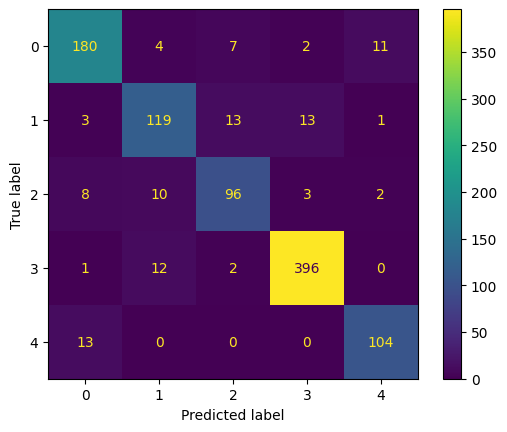

In [11]:
cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [12]:
accuracy_score(y_test, predictions)
# (TP + TN) / (TP + FP + FN + TN)

precision_score(y_test, predictions, average='micro')
# TP / (TP + FP)

recall_score(y_test, predictions, average='micro')
# TP / (TP + FN)

0.895

0.895

0.895

# Reading the test dataset

In [13]:
test_df.head()
test_df.info()
test_df.describe()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
0,Guimaraes,UNDEFINED,1211,"N101,N101,N101,N101,N101,N101,",2021-04-13 19:00,LIGHT,15.0,1018.0,80.0,0.0,0.0,Sem Chuva
1,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-13 04:00,DARK,16.0,1018.0,41.0,2.0,0.0,Sem Chuva
2,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-18 19:00,LIGHT,22.0,1017.0,71.0,0.0,0.0,Sem Chuva
3,Guimaraes,UNDEFINED,140,"N101,R206,N101,N101,N101,N101",2021-10-30 15:00,LIGHT,18.0,1008.0,81.0,3.0,0.0,Sem Chuva
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-18 10:00,LIGHT,20.0,1022.0,86.0,0.0,0.0,Sem Chuva


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           1206 non-null   object 
 1   magnitude_of_delay  1206 non-null   object 
 2   delay_in_seconds    1206 non-null   int64  
 3   affected_roads      1184 non-null   object 
 4   record_date         1206 non-null   object 
 5   luminosity          1206 non-null   object 
 6   avg_temperature     1206 non-null   float64
 7   avg_atm_pressure    1206 non-null   float64
 8   avg_humidity        1206 non-null   float64
 9   avg_wind_speed      1206 non-null   float64
 10  avg_precipitation   1206 non-null   float64
 11  avg_rain            1206 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 113.2+ KB


,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.0
mean,565.080431,14.649254,1018.024876,73.865672,1.332504,0.0
std,1584.544376,4.691180,5.338753,17.202341,1.337510,0.0
min,0.000000,2.000000,999.000000,7.000000,0.000000,0.0
25%,0.000000,11.000000,1015.000000,62.000000,0.000000,0.0
50%,0.000000,14.000000,1018.000000,77.000000,1.000000,0.0
75%,268.750000,18.000000,1022.000000,90.000000,2.000000,0.0
max,14866.000000,30.000000,1031.000000,100.000000,9.000000,0.0


In [14]:
X = decision_tree_data_preparation(test_df)

# Getting the predictions

In [15]:
predictions = clf.predict(X)

predictions_df = pd.DataFrame(predictions)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')